# RecLM

A recurrent language model is trained, with the following features:

1. WeightDrop on the RNN layers
2. Variational dropout on the embedding layer
3. Weight tie in between the embedding layer, and final linear layer which outputs a one-hot encoding
4. Variable back propagation through time
5. Independent embedding sizes and hidden sizes
6. Activation Regularization and Temporal Activation Regularization
7. Variational dropout on all other layers

This is effectively the language model described in [this paper](https://arxiv.org/abs/1708.02182)

In [1]:
# % load_ext autoreload
# % autoreload 2
% matplotlib inline

In [2]:
from pathlib import Path
import pickle
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
from torch import nn

In [3]:
from lm.data import LMDataLoader
from lm.models import RecLM, ARTAR, accuracy
from lm.schedulers import OneCycle

In [4]:
device = torch.device("cuda:0")
# device = torch.device('cpu')

Loading the data, making dataloaders

In [5]:
dict_path = Path('word2int.pickle')
with dict_path.open('rb') as file:
    d = pickle.load(file)

In [6]:
xtrain = np.load('wikitext_train_int_tokens.npy')
xval = np.load('wikitext_valtest_int_tokens.npy')

In [7]:
xtrain_tensor = torch.from_numpy(xtrain).long()
xval_tensor = torch.from_numpy(xval).long()

if device.type == 'cuda':
    xtrain_tensor = xtrain_tensor.cuda()
    xval_tensor = xval_tensor.cuda()

In [8]:
train_dataloader = LMDataLoader(xtrain_tensor, 70, 64)
val_dataloader = LMDataLoader(xval_tensor, 70, 64)

In [9]:
vocab_size = len(d)
padding_idx = d['_pad_']

In [10]:
model = RecLM(vocab_size=vocab_size, padding_idx=padding_idx).cuda()

In [11]:
model

RecLM(
  (embedding): VDEmbedding(
    (embedding): Embedding(30002, 400, padding_idx=0)
  )
  (wdrnn_0): WDLSTM(
    (lstm): LSTM(400, 1150)
  )
  (wdrnn_1): WDLSTM(
    (lstm): LSTM(1150, 1150)
  )
  (wdrnn_2): WDLSTM(
    (lstm): LSTM(1150, 400)
  )
  (decoder): Linear(in_features=400, out_features=30002, bias=True)
  (emb_drop): VariationalDropout()
  (final_rnn_drop): VariationalDropout()
)

Finally, define our losses

In [12]:
crit = nn.CrossEntropyLoss()
regularizing_loss = ARTAR()

I kept getting out of memory errors when finding the min and max learning rates (presumably from removing `flatten_parameters`), but I was able to figure out a `max_lr` of `0.03`

First, lets just train the embedding layer for one epoch

In [13]:
emb_optimizer = torch.optim.Adam([pam for name, pam in model.named_parameters() if 'embedding' in name])

In [14]:
emb_scheduler = OneCycle(emb_optimizer, len(train_dataloader), upswing=0.1, downswing=0.9, min_lr=1e-5,
                         max_lr=0.03)

In [15]:
hidden = [None, None, None]

In [18]:
# set the model to train
model.train()
# keep track of training scores, so they can be displayed later
train_scores = defaultdict(list)

for batch_number, batch in (enumerate(tqdm(train_dataloader))):
    # Zero the gradients of my optimizer - 'reset' it
    emb_optimizer.zero_grad()

    x, y = batch
    pred, hidden, finals = model(x, hidden)

    loss = crit(pred, y)
    acc = accuracy(pred, y)
    reg = regularizing_loss(finals)

    train_scores['loss'].append(loss.item())
    train_scores['reg'].append(reg.item())
    train_scores['accuracy'].append(acc)

    total_loss = loss + reg
    total_loss.backward()
    emb_optimizer.step()
    emb_scheduler.step()

train_output_strings = []
for key, val in train_scores.items():
    mean_value = np.array(val).mean()
    train_output_strings.append('{}: {}'.format(key, round(mean_value, 5)))

if val_dataloader:
    model.eval()
    val_scores = defaultdict(list)
    with torch.no_grad():
        for batch_number, batch in enumerate(val_dataloader):
            x, y = batch
            pred = model(x, hidden)
            val_loss = crit(pred, y)
            acc = accuracy(pred, y)

            val_scores['loss'].append(val_loss)
            val_scores['accuracy'].append(acc)

    val_output_strings = []
    for key, val in val_scores.items():
        mean_value = np.array(val).mean()
        val_output_strings.append('{}: {}'.format(key, round(mean_value, 5)))
print('TRAINING: {}, {}, {}'.format(*train_output_strings))
print('VALIDATION: {}, {}'.format(*val_output_strings))

  0%|          | 0/514 [00:00<?, ?it/s]/home/ubuntu/workdir/language_model/lm/models/awd_lstm.py:63: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  output, (hn, cn) = self.lstm(x, h0)
 91%|█████████▏| 470/514 [03:37<00:20,  2.16it/s]


TRAINING: loss: 10.50497, reg: 176.50127, accuracy: 0.02287
VALIDATION: loss: 9.91312026977539, accuracy: 0.0317


Then, everything

In [19]:
optimizer = torch.optim.Adam(model.parameters())

In [21]:
scheduler = OneCycle(optimizer, len(train_dataloader), upswing=2, downswing=18, min_lr=1e-5,
                         max_lr=0.03)

In [22]:
num_epochs = scheduler.num_epochs()

In [23]:
hidden = [None, None, None]

In [24]:
overall_train = defaultdict(list)
overall_val = defaultdict(list)

for epoch in range(num_epochs):
    # set the model to train
    model.train()
    # keep track of training scores, so they can be displayed later
    train_scores = defaultdict(list)
    
    for batch_number, batch in (enumerate(tqdm(train_dataloader))):
        # Zero the gradients of my optimizer - 'reset' it
        optimizer.zero_grad()
        
        x, y = batch
        pred, hidden, finals = model(x, hidden)
        
        loss = crit(pred, y)
        acc = accuracy(pred, y)
        reg = regularizing_loss(finals)
        
        train_scores['loss'].append(loss.item())
        train_scores['reg'].append(reg.item())
        train_scores['accuracy'].append(acc)
        
        total_loss = loss + reg
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        
    train_output_strings = []
    for key, val in train_scores.items():
        mean_value = np.array(val).mean()
        train_output_strings.append('{}: {}'.format(key, round(mean_value, 5)))
        overall_train[key].append(mean_value)
        
    if val_dataloader:
        model.eval()
        val_scores = defaultdict(list)
        with torch.no_grad():
            for batch_number, batch in enumerate(val_dataloader):
                x, y = batch
                pred = model(x, hidden)
                val_loss = crit(pred, y)
                acc = accuracy(pred, y)
                
                val_scores['loss'].append(val_loss)
                val_scores['accuracy'].append(acc)
                
        val_output_strings = []
        for key, val in val_scores.items():
            mean_value = np.array(val).mean()
            val_output_strings.append('{}: {}'.format(key, round(mean_value, 5)))
            overall_val[key].append(mean_value)
        print('TRAINING: {}, {}, {}'.format(*train_output_strings))
        print('VALIDATION: {}, {}'.format(*val_output_strings))

  0%|          | 0/514 [00:00<?, ?it/s]/home/ubuntu/workdir/language_model/lm/models/awd_lstm.py:63: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  output, (hn, cn) = self.lstm(x, h0)
  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 9.32187, reg: 2.86542, accuracy: 0.04938
VALIDATION: loss: 7.926199913024902, accuracy: 0.06518


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.33905, reg: 0.00886, accuracy: 0.06292
VALIDATION: loss: 6.890789985656738, accuracy: 0.06265


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.11299, reg: 0.00013, accuracy: 0.06207
VALIDATION: loss: 6.9276299476623535, accuracy: 0.06265


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.11002, reg: 9e-05, accuracy: 0.06164
VALIDATION: loss: 6.868390083312988, accuracy: 0.06533


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.10361, reg: 6e-05, accuracy: 0.06214
VALIDATION: loss: 6.9255900382995605, accuracy: 0.06696


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.10758, reg: 3e-05, accuracy: 0.06389
VALIDATION: loss: 6.898859977722168, accuracy: 0.06611


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.07384, reg: 2e-05, accuracy: 0.06124
VALIDATION: loss: 6.827139854431152, accuracy: 0.06682


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.10515, reg: 4e-05, accuracy: 0.06257
VALIDATION: loss: 6.804969787597656, accuracy: 0.06177


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.09353, reg: 2e-05, accuracy: 0.06083
VALIDATION: loss: 6.895440101623535, accuracy: 0.06607


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.11622, reg: 0.00015, accuracy: 0.06234
VALIDATION: loss: 6.842700004577637, accuracy: 0.06553


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.08299, reg: 0.01554, accuracy: 0.06283
VALIDATION: loss: 6.821400165557861, accuracy: 0.0682


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.0662, reg: 0.0, accuracy: 0.06423
VALIDATION: loss: 6.924379825592041, accuracy: 0.06235


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.06299, reg: 0.0, accuracy: 0.06194
VALIDATION: loss: 6.890039920806885, accuracy: 0.0616


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.0505, reg: 0.0, accuracy: 0.06211
VALIDATION: loss: 6.826089859008789, accuracy: 0.06958


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.06006, reg: 0.0, accuracy: 0.0605
VALIDATION: loss: 6.833539962768555, accuracy: 0.05997


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.07822, reg: 0.0, accuracy: 0.062
VALIDATION: loss: 6.824190139770508, accuracy: 0.06503


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.04108, reg: 0.0, accuracy: 0.06276
VALIDATION: loss: 6.858349800109863, accuracy: 0.06553


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.08471, reg: 0.0, accuracy: 0.0621
VALIDATION: loss: 6.773670196533203, accuracy: 0.07181


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.05181, reg: 0.0, accuracy: 0.06266
VALIDATION: loss: 6.871200084686279, accuracy: 0.06265


 91%|█████████ | 469/514 [03:39<00:21,  2.14it/s]


TRAINING: loss: 7.08383, reg: 0.0, accuracy: 0.06197
VALIDATION: loss: 6.793970108032227, accuracy: 0.06711


In [25]:
model_information = {'state_dict': model.state_dict(),
                     'val_acc': overall_val['accuracy'],
                     'val_loss': overall_val['loss'],
                     'train_acc': overall_train['accuracy'],
                     'train_loss': overall_train['loss'],}
torch.save(model_information, 'RecLM_L3.pth.tar')

In [26]:
from lm.models import perplexity

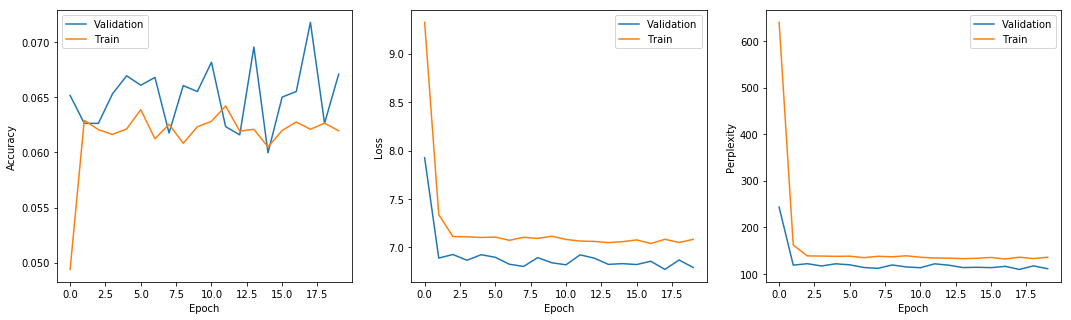

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))

# First, lets plot accuracy
axes[0].plot(range(len(overall_val['accuracy'])), overall_val['accuracy'], label='Validation')
axes[0].plot(range(len(overall_train['accuracy'])), overall_train['accuracy'], label='Train')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# then, loss
axes[1].plot(range(len(overall_val['loss'])), overall_val['loss'], label='Validation')
axes[1].plot(range(len(overall_train['loss'])), overall_train['loss'], label='Train')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Finally, perplexity
val_perplexity = [perplexity(x) for x in overall_val['loss']]
train_perplexity = [perplexity(x) for x in overall_train['loss']]
axes[2].plot(range(len(val_perplexity)), val_perplexity, label='Validation')
axes[2].plot(range(len(train_perplexity)), train_perplexity, label='Train')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Perplexity')
axes[2].legend()